## Import libraries

In [18]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Download data

In [3]:
aoi_dir = f'../../data/external/temporal_todocker/arroyo_vivo/cuenca_arroyo_32614.gpkg'
resolutions = [11]

<Axes: >

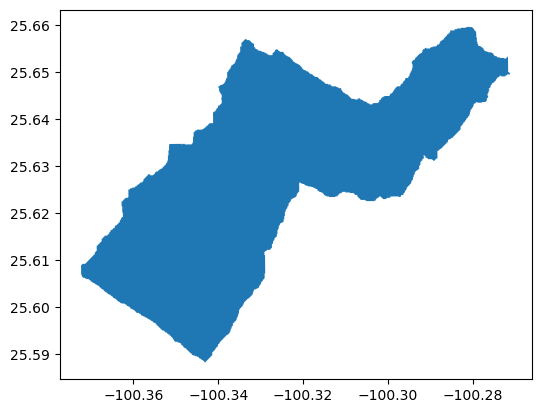

In [4]:
aoi = gpd.read_file(aoi_dir)
aoi = aoi.to_crs("EPSG:4326")

# Show
aoi.plot()

In [5]:
# Referencia
schema = 'projects_research'
table = 'arroyovivo_residuosjornada_point'
query = f"SELECT * FROM {schema}.{table}"
pois = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(pois.shape)
pois.head(1)

(13451, 11)


,id,itemname,tipo,material,quantity,latitude,longitude,altitude,datetime,jornada,geometry
0,2251010,Bolsa de plástico para comestibles,Productos Plásticos para Comida,plastico,5,25.641495,-100.293776,530.400024,2022-10-29 14:05:31+00:00,221029,MULTIPOINT ((-100.29378 25.64149))


## Process data

### Process data - Create hexgrid and count by hex residuos and jornadas

In [7]:
# Create buffer for aoi in order to create a hexgrid that includes all the area
aoi_buffer = aoi.to_crs("EPSG:6372").buffer(60)
aoi_buffer = aoi_buffer.to_crs("EPSG:4326")
aoi_buffer = gpd.GeoDataFrame(geometry=aoi_buffer).dissolve()

# Go back to EPSG:4326
aoi = aoi.to_crs("EPSG:4326")

In [12]:
materiales_list = list(pois.material.unique())
jornadas_list = list(pois.jornada.unique())

pois_copy = pois.copy()
pois_copy.loc[:,'count'] = 1

i = 0

for res in resolutions:
    print(f"STARTING ANALYSIS FOR RES {res}")
    # Create hexgrid
    hexgrid = aup.create_hexgrid(aoi_buffer,res)
    
    # Duplicate hexgrid to merge later
    summary_tmp = hexgrid.copy()
    
    j = 1
    for material in materiales_list:
        print(f"Counting material {j} of {len(materiales_list)}: {material}")
        
        pois_process = pois_copy.loc[pois.material == material]
        pois_inhex = gpd.sjoin(pois_process, hexgrid)

        # Sum by hex count (individual points) and quantity (how much trash was registered in that point)
        groupby = pois_inhex.groupby(f'hex_id_{res}').agg({'count':np.sum,
                                                           'quantity':np.sum})
        groupby.rename(columns={'count':material,
                                'quantity':f'{material}_quantity'},inplace=True)
        groupby = groupby[[material,f'{material}_quantity']]

        # Join groupby with geometry
        summary_tmp = pd.merge(summary_tmp,groupby, on=f'hex_id_{res}',how='outer')
        
        j = j+1
        
    k = 1
    for jornada in jornadas_list:
        print(f"Counting jornada {k} of {len(jornadas_list)}: {jornada}")
        
        pois_process = pois_copy.loc[pois.jornada == jornada]
        pois_inhex = gpd.sjoin(pois_process, hexgrid)
        
        # Create tot column for this jornada (points and quantity)
        groupby = pois_inhex.groupby(f'hex_id_{res}').agg({'count':np.sum,
                                                           'quantity':np.sum})
        groupby.rename(columns={'count':f'{jornada}_points',
                                'quantity':f'{jornada}_quantity'},inplace=True)
        groupby = groupby[[f'{jornada}_points',f'{jornada}_quantity']]
        
        # Add this jornada to the jornadas_count column
        groupby[jornada] = 1
        
         # Join groupby with geometry
        summary_tmp = pd.merge(summary_tmp,groupby, on=f'hex_id_{res}',how='outer')
        
        k = k+1

    # Add resolution currently processed and change hex_id column name
    summary_tmp['res'] = res
    summary_tmp.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
        
    if i == 0:
        summary = summary_tmp.copy()
    else:
        summary = pd.concat([summary,summary_tmp])
        
    i = i+1

# Show -----------------------------------------------
print(summary.shape)
summary.head(1)

STARTING ANALYSIS FOR RES 11
Counting material 1 of 23: plastico
Counting material 2 of 23: tabaco
Counting material 3 of 23: unicel/plastico
Counting material 4 of 23: metal
Counting material 5 of 23: vidrio
Counting material 6 of 23: llantas
Counting material 7 of 23: tela
Counting material 8 of 23: madera
Counting material 9 of 23: escombros
Counting material 10 of 23: papel
Counting material 11 of 23: carton
Counting material 12 of 23: otros
Counting material 13 of 23: unicel
Counting material 14 of 23: electronica
Counting material 15 of 23: organico
Counting material 16 of 23: vidrio/ceramica
Counting material 17 of 23: EPI
Counting material 18 of 23: salud e higiene
Counting material 19 of 23: plastico/tela
Counting material 20 of 23: pesca
Counting material 21 of 23: baterias
Counting material 22 of 23: goma
Counting material 23 of 23: cenizas
Counting jornada 1 of 21: 221029
Counting jornada 2 of 21: 220924
Counting jornada 3 of 21: 220705
Counting jornada 4 of 21: 220822
Coun

,hex_id,geometry,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,230311_points,230311_quantity,230311,230530_points,230530_quantity,230530,230419_points,230419_quantity,230419,res
0,8b48a202b326fff,"POLYGON ((-100.29184 25.64380, -100.29166 25.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


### Process data - Sum counted data (#Jornadas, total garbage points, total quantity and most_common residuo)

In [13]:
# Additional data -----------------------------------------------
# Remove NaNs
summary = summary.fillna(0)

# Count jornadas by hex and drop individual count columns
summary['jornadas_count'] = summary[jornadas_list].sum(axis=1)
summary.drop(columns=jornadas_list,inplace=True)
print("Counted jornadas")

# Sum total garbage points by hex and find most common residue by total data
summary['total_points'] = summary[materiales_list].sum(axis=1)
summary['most_common_point'] = summary[materiales_list].idxmax(axis=1)

# Sum total garbage quantity by hex and find most common residue by total quantity data
materiales_quantity_list = []
for material in materiales_list:
    column_name = f'{material}_quantity'
    materiales_quantity_list.append(column_name)
    
summary['total_quantity'] = summary[materiales_quantity_list].sum(axis=1)
summary['most_common_quantity'] = summary[materiales_quantity_list].idxmax(axis=1)

print("Found total points, quantity and most commmon residuo.")

# Delete hexs without data
idx = summary['total_points'] != 0
summary_f = summary.loc[idx]
#Sort values 
summary_f = summary_f.sort_values(by='total_points',ascending=False)

# Show -----------------------------------------------
print(summary_f.shape)
summary_f.head(1)

Counted jornadas
Found total points, quantity and most commmon residuo.
(419, 96)


,hex_id,geometry,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,230530_points,230530_quantity,230419_points,230419_quantity,res,jornadas_count,total_points,most_common_point,total_quantity,most_common_quantity
9259,8b48a202baacfff,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",122.0,616.0,0.0,0.0,15.0,58.0,2.0,2.0,...,0.0,0.0,0.0,0.0,11,4.0,658.0,tela,1432.0,plastico_quantity


### Review output before proceeding to further analysis

In [16]:
# Review original vs processed total points and total quantity
print(f'Original total: {pois.shape[0]}')
print(f'total after groupby: {(summary_f.total_points.sum())/(len(resolutions))}')

print(f'Original total quantity: {pois.quantity.sum()}')
print(f'total quantity after groupby: {(summary_f.total_quantity.sum())/(len(resolutions))}')

Original total: 13451
total after groupby: 13451.0
Original total quantity: 21203
total quantity after groupby: 21203.0


In [17]:
# Verify: Points divided in each jornada column == total points?

# Create list of columns to review
jornadas_points_columns = []
for jornada in jornadas_list:
    column_name = f'{jornada}_points'
    jornadas_points_columns.append(column_name)
    
# Sum values on columns to review
prueba = summary_f.copy()
prueba['jornadas_points_checker'] = prueba[jornadas_points_columns].sum(axis=1)
prueba['diff'] = prueba['total_points'] - prueba['jornadas_points_checker']

# Print result
resultado = prueba['diff'].sum()
print(f'points_diff: {resultado}')

# ------------------------------------------------------------------------------
# Verify: Quantity divided in each jornada column == total quantity?

# Create list of columns to review
jornadas_quantity_columns = []
for jornada in jornadas_list:
    column_name = f'{jornada}_quantity'
    jornadas_quantity_columns.append(column_name)

# Sum values on columns to review
prueba = summary_f.copy()
prueba['jornadas_quantity_checker'] = prueba[jornadas_quantity_columns].sum(axis=1)
prueba['diff'] = prueba['total_quantity'] - prueba['jornadas_quantity_checker']

# Print result
resultado = prueba['diff'].sum()
print(f'quantity_diff: {resultado}')

points_diff: 0.0
quantity_diff: 0.0


### Process data - Add additional analysis data

In [21]:
# New analysis data
summary_f['totalpoints/jornadascount'] = summary_f['total_points'] / summary_f['jornadas_count']
summary_f['totalquantity/jornadascount'] = summary_f['total_quantity'] / summary_f['jornadas_count']
summary_f['log10(points/jornadas)'] = np.log10(summary_f['total_points'] / summary_f['jornadas_count'])
summary_f['log10(quantity/jornadas)'] = np.log10(summary_f['total_quantity'] / summary_f['jornadas_count'])

# Show
print(summary_f.shape)
summary_f.head(1)

(419, 100)


,hex_id,geometry,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,res,jornadas_count,total_points,most_common_point,total_quantity,most_common_quantity,totalpoints/jornadascount,totalquantity/jornadascount,log10(points/jornadas),log10(quantity/jornadas)
9259,8b48a202baacfff,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",122.0,616.0,0.0,0.0,15.0,58.0,2.0,2.0,...,11,4.0,658.0,tela,1432.0,plastico_quantity,164.5,358.0,2.216166,2.553883


In [23]:
summary_f.columns

Index(['hex_id', 'geometry', 'plastico', 'plastico_quantity', 'tabaco',
       'tabaco_quantity', 'unicel/plastico', 'unicel/plastico_quantity',
       'metal', 'metal_quantity', 'vidrio', 'vidrio_quantity', 'llantas',
       'llantas_quantity', 'tela', 'tela_quantity', 'madera',
       'madera_quantity', 'escombros', 'escombros_quantity', 'papel',
       'papel_quantity', 'carton', 'carton_quantity', 'otros',
       'otros_quantity', 'unicel', 'unicel_quantity', 'electronica',
       'electronica_quantity', 'organico', 'organico_quantity',
       'vidrio/ceramica', 'vidrio/ceramica_quantity', 'EPI', 'EPI_quantity',
       'salud e higiene', 'salud e higiene_quantity', 'plastico/tela',
       'plastico/tela_quantity', 'pesca', 'pesca_quantity', 'baterias',
       'baterias_quantity', 'goma', 'goma_quantity', 'cenizas',
       'cenizas_quantity', '221029_points', '221029_quantity', '220924_points',
       '220924_quantity', '220705_points', '220705_quantity', '220822_points',
       '22

In [24]:
summary_f = summary_f [['hex_id', 'res', 
                        # Data by residuo
                        'plastico', 'plastico_quantity', 'tabaco',
                        'tabaco_quantity', 'unicel/plastico', 'unicel/plastico_quantity',
                        'metal', 'metal_quantity', 'vidrio', 'vidrio_quantity', 'llantas',
                        'llantas_quantity', 'tela', 'tela_quantity', 'madera',
                        'madera_quantity', 'escombros', 'escombros_quantity', 'papel',
                        'papel_quantity', 'carton', 'carton_quantity', 'otros',
                        'otros_quantity', 'unicel', 'unicel_quantity', 'electronica',
                        'electronica_quantity', 'organico', 'organico_quantity',
                        'vidrio/ceramica', 'vidrio/ceramica_quantity', 'EPI', 'EPI_quantity',
                        'salud e higiene', 'salud e higiene_quantity', 'plastico/tela',
                        'plastico/tela_quantity', 'pesca', 'pesca_quantity', 'baterias',
                        'baterias_quantity', 'goma', 'goma_quantity', 'cenizas',
                        'cenizas_quantity',
                        # Data by jornada
                        '221029_points', '221029_quantity', '220924_points',
                        '220924_quantity', '220705_points', '220705_quantity', '220822_points',
                        '220822_quantity', '220827_points', '220827_quantity', '220823_points',
                        '220823_quantity', '220824_points', '220824_quantity', '220829_points',
                        '220829_quantity', '220818_points', '220818_quantity', '221130_points',
                        '221130_quantity', '221201_points', '221201_quantity', '230415_points',
                        '230415_quantity', '230527_points', '230527_quantity', '230713_points',
                        '230713_quantity', '230819_points', '230819_quantity', '230817_points',
                        '230817_quantity', '230109_points', '230109_quantity', '230203_points',
                        '230203_quantity', '230311_points', '230311_quantity', '230530_points',
                        '230530_quantity', '230419_points', '230419_quantity',
                        # Summary data
                        'jornadas_count', 'total_points', 'most_common_point', 'total_quantity','most_common_quantity',
                        # Analysis data
                        'totalpoints/jornadascount','totalquantity/jornadascount','log10(points/jornadas)','log10(quantity/jornadas)',
                        # Geometry
                        'geometry']]

summary_f.head(1)

,hex_id,res,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,jornadas_count,total_points,most_common_point,total_quantity,most_common_quantity,totalpoints/jornadascount,totalquantity/jornadascount,log10(points/jornadas),log10(quantity/jornadas),geometry
9259,8b48a202baacfff,11,122.0,616.0,0.0,0.0,15.0,58.0,2.0,2.0,...,4.0,658.0,tela,1432.0,plastico_quantity,164.5,358.0,2.216166,2.553883,"POLYGON ((-100.29357 25.64128, -100.29339 25.6..."


In [25]:
# Make all columns .lower()
columns = summary_f.columns
for column in columns:
    summary_f.rename(columns={column:column.lower()},inplace=True)

summary_f.head(1)

,hex_id,res,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,jornadas_count,total_points,most_common_point,total_quantity,most_common_quantity,totalpoints/jornadascount,totalquantity/jornadascount,log10(points/jornadas),log10(quantity/jornadas),geometry
9259,8b48a202baacfff,11,122.0,616.0,0.0,0.0,15.0,58.0,2.0,2.0,...,4.0,658.0,tela,1432.0,plastico_quantity,164.5,358.0,2.216166,2.553883,"POLYGON ((-100.29357 25.64128, -100.29339 25.6..."


## Save output

In [13]:
summary_f.to_file(f'../../data/external/temporal_fromjupyter/arroyo_vivo/residuosarroyo_hex.gpkg')

In [26]:
aup.gdf_to_db_slow(summary_f, 'arroyovivo_residuosjornada_hex','projects_research', if_exists='replace')

## Upload other things

In [15]:
#buffer_dir = f'../../data/external/temporal_todocker/arroyo_vivo/arroyo_buffer200mts_32614.gpkg'
#buffer = gpd.read_file(buffer_dir)
#buffer = buffer.to_crs("EPSG:4326")

In [16]:
#buffer = buffer[['geometry']]
#buffer

In [17]:
#buffer.plot()

In [18]:
#aup.gdf_to_db_slow(buffer, 'arroyovivo_buffer200mts','projects_research', if_exists='replace')